In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
batch='WILD_with_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_with_father.npy', 
                                   allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [6]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='energy')

In [7]:
data_ncells = pd.read_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'_energy.csv')

# Format data for hierarchy plotting

In [8]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS for all areas and energy

In [10]:
%%bash
python area_pls.py -i results_pls/WILD_with_father_n_cells.csv -o './results_pls/WILD_with_father'

2023-08-15 18:18:28 PC1QFRRQ __main__[357034] INFO reading data...
2023-08-15 18:18:28 PC1QFRRQ __main__[357034] INFO computing PLS...
2023-08-15 18:18:28 PC1QFRRQ __main__[357034] INFO PLS computed, now performing bootstrap...
2023-08-15 18:18:28 PC1QFRRQ __main__[357034] INFO saving output data...


In [11]:
%%bash
python area_pls.py -i results_pls/WILD_with_father_energy.csv -o './results_pls/WILD_with_father_energy'

2023-08-15 18:18:33 PC1QFRRQ __main__[357043] INFO reading data...
2023-08-15 18:18:33 PC1QFRRQ __main__[357043] INFO computing PLS...
Traceback (most recent call last):
  File "area_pls.py", line 58, in <module>
    main()
  File "area_pls.py", line 42, in main
    u, s, v = pls(xm, ym)
  File "/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_PLS.py", line 73, in pls
    u, s, v = np.linalg.svd(r, full_matrices=False)
  File "<__array_function__ internals>", line 6, in svd
  File "/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1626, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 106, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


CalledProcessError: Command 'b"python area_pls.py -i results_pls/WILD_with_father_energy.csv -o './results_pls/WILD_with_father_energy'\n"' returned non-zero exit status 1.

# Plot results

In [12]:
contrasts = pd.read_csv('./results_pls/WILD_with_father_contrasts.csv')
saliences = pd.read_csv('./results_pls/WILD_with_father_saliences.csv')
contrasts = contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

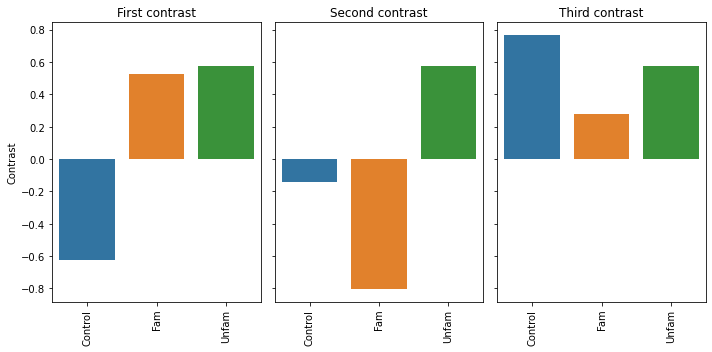

In [13]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=contrasts, index=0, ax=axes[0])
upls.plot_contrasts(df_data=contrasts, index=1, ax=axes[1])
upls.plot_contrasts(df_data=contrasts, index=2, ax=axes[2])
axes[0].set_ylabel('Contrast')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_all_areas.png')
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_all_areas.svg')

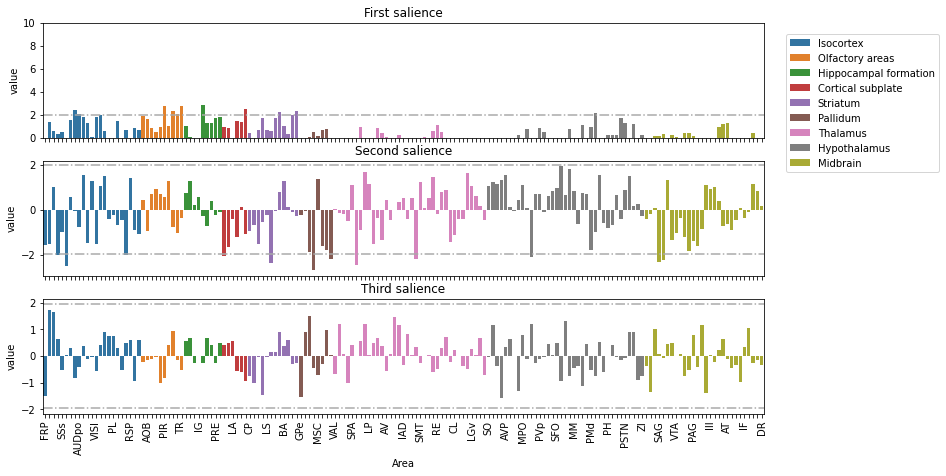

In [14]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=saliences, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=saliences, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=saliences, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(0,10)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
plt.savefig('./results_pls/WILD_with_father_pls_saliences_all_areas.png')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_all_areas.svg')

# Identify areas with significant salience contribution

In [16]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=2.58, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas_WILD_with_father.npy', pls_sig_areas)

In [17]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_WILD_with_father.npy', allow_pickle=True)
pls_sig_areas

array(['Entorhinal area', 'Magnocellular nucleus', 'Piriform area',
       'Postpiriform transition area'], dtype='<U28')

# Apply PLS for all significant areas in ncells and energy

In [18]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'_energy_filt.csv')

In [19]:
%%bash
python area_pls.py -i results_pls/WILD_with_father_n_cells_filt.csv -o './results_pls/WILD_with_father_filt'

2023-08-15 18:19:55 PC1QFRRQ __main__[357145] INFO reading data...
2023-08-15 18:19:55 PC1QFRRQ __main__[357145] INFO computing PLS...
2023-08-15 18:19:55 PC1QFRRQ __main__[357145] INFO PLS computed, now performing bootstrap...
2023-08-15 18:19:56 PC1QFRRQ __main__[357145] INFO saving output data...


In [20]:
%%bash
python area_pls.py -i results_pls/WILD_with_father_energy_filt.csv -o './results_pls/WILD_with_father_energy_filt'

2023-08-15 18:19:57 PC1QFRRQ __main__[357151] INFO reading data...
2023-08-15 18:19:57 PC1QFRRQ __main__[357151] INFO computing PLS...
2023-08-15 18:19:57 PC1QFRRQ __main__[357151] INFO PLS computed, now performing bootstrap...
2023-08-15 18:19:58 PC1QFRRQ __main__[357151] INFO saving output data...


## Look at the number of cells

In [21]:
contrasts_filt = pd.read_csv('./results_pls/WILD_with_father_filt_contrasts.csv')
saliences_filt = pd.read_csv('./results_pls/WILD_with_father_filt_saliences.csv')
contrasts_filt = contrasts_filt.rename(columns={"group_Control": "Control", 
                                                        "group_Fam": "Fam", 
                                                        "group_Unfam":"Unfam"})

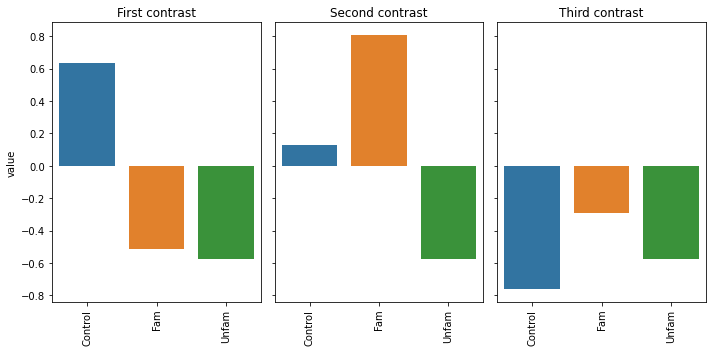

In [22]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=contrasts_filt, index=0, ax=axes[0])
upls.plot_contrasts(df_data=contrasts_filt, index=1, ax=axes[1])
upls.plot_contrasts(df_data=contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_sig_areas.png')

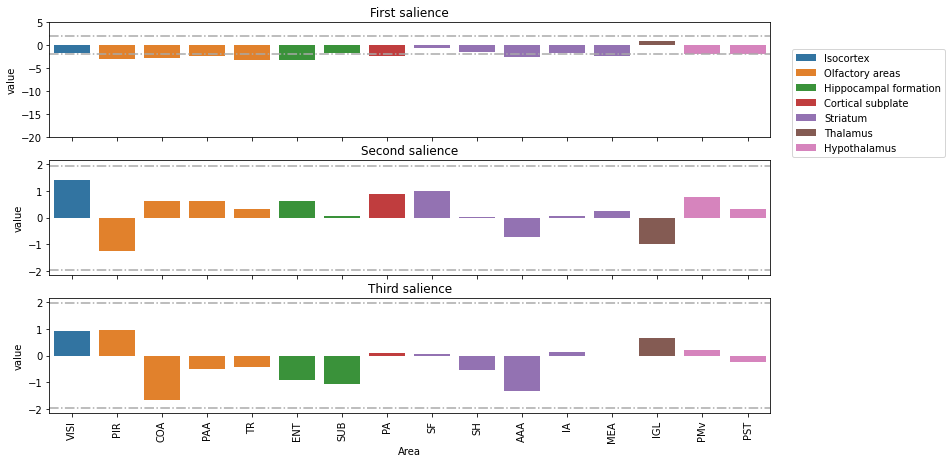

In [23]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=saliences_filt, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=saliences_filt, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=saliences_filt, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-20,5)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_sig_areas.png')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_sig_areas.svg')

## Look at the energy

In [24]:
contrasts_filt_energy = pd.read_csv('./results_pls/WILD_with_father_energy_filt_contrasts.csv')
saliences_filt_energy = pd.read_csv('./results_pls/WILD_with_father_energy_filt_saliences.csv')
contrasts_filt_energy = contrasts_filt.rename(columns={"group_Control": "Control", 
                                                        "group_Fam": "Fam", 
                                                        "group_Unfam":"Unfam"})

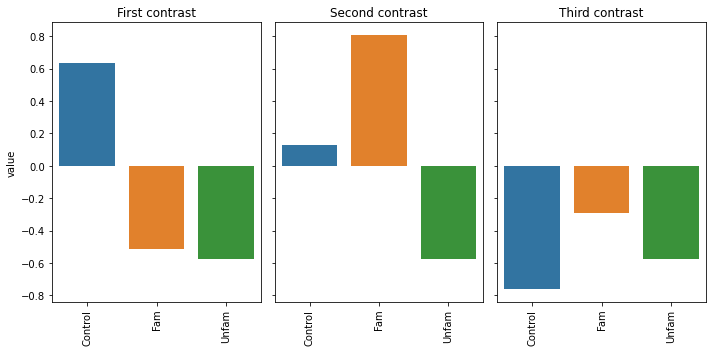

In [25]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=contrasts_filt_energy, index=0, ax=axes[0])
upls.plot_contrasts(df_data=contrasts_filt_energy, index=1, ax=axes[1])
upls.plot_contrasts(df_data=contrasts_filt_energy, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/WILD_with_father_pls_contrasts_sig_areas.png')

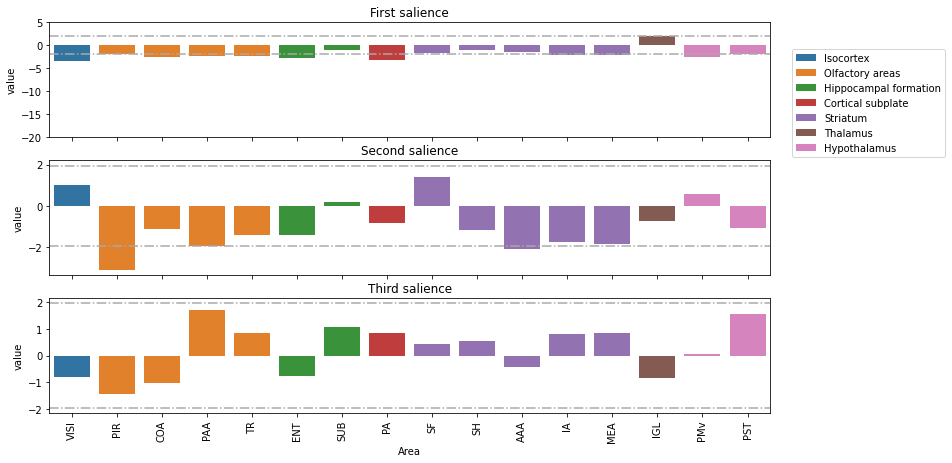

In [26]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=saliences_filt_energy, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=saliences_filt_energy, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=saliences_filt_energy, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-20,5)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_sig_areas_energy.png')
plt.savefig('./results_pls/WILD_with_father_pls_saliences_sig_areas_energy.svg')

# Identify areas with significant salience contribution

In [27]:
# pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=saliences_filt, 
#                                        threshold=1.96, 
#                                        volumes=volumes)
# pls_sig_areas_filt

In [26]:
pls_sig_areas

array(['Anterior tegmental nucleus', 'Endopiriform nucleus',
       'Infralimbic area', 'Paraventricular nucleus of the thalamus',
       'Primary visual area', 'Tuberal nucleus'], dtype='<U39')